# Сборный проект № 2. A/A/B-тест в приложении

## Информация о проекте

### Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

### Описание данных

Каждая запись в логе — это действие пользователя, или событие. 

*EventName* — название события;

*DeviceIDHash* — уникальный идентификатор пользователя;

*EventTimestamp* — время события;

*ExpId* — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### План работы

1. Загрузка данных и изучение общей информации, предобработка 
3. Ознакомление с данными и их проверка
4. Изучение воронки событий
5. Анализ результатов эксперимента

## Загрузка данных и изучение общей информации, предобработка

In [1]:
#Загружаю необходимые библиотеки
import pandas as pd
from scipy import stats as st
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import math as mth
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

display(df.head(10))
display(df.info())
print('Количество пропусков:', df.isnull().sum())
print('Количество дубликатов:', df.duplicated().sum())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Количество пропусков: EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64
Количество дубликатов: 413


В таблице 244126 строк, 4 столбца: EventName, DeviceIDHash, EventTimestamp, ExpId. Далее отредактирую названия столбцов.

Пропусков в данных нет, но есть 413 дубликатов, их нужно будет удалить (объем данных позволяет). 

Изменю тип данных в столбце EventTimestamp, добавлю дополнительные столбцы с датой и временем и датой. 



In [3]:
# Меняю запись названий столбцов
df.rename(columns = {'EventName':'event_name', 'DeviceIDHash':'device_id_hash', 'EventName':'event_name', 'EventTimestamp':'event_timestamp', 'ExpId':'exp_id' }, inplace = True )
display(df.head())

,event_name,device_id_hash,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
#Убираю дубликаты
df = df.drop_duplicates().reset_index(drop=True) 
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [5]:
#Добавляю столдцы с датой и временем и датой
df['event_date_time'] = pd.to_datetime(df['event_timestamp'], unit = 's')  
df['event_dt'] = pd.to_datetime(df['event_timestamp'], unit = 's').dt.date

display(df.head())
display(df.info())

,event_name,device_id_hash,event_timestamp,exp_id,event_date_time,event_dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   event_date_time  243713 non-null  datetime64[ns]
 5   event_dt         243713 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 11.2+ MB


None

## Ознакомление с данными и их проверка

### Сколько всего событий в логе?

In [6]:
print('Количество событий в логе:', df['event_name'].count())

Количество событий в логе: 243713


### Сколько всего пользователей в логе?

In [7]:
print('Количество пользователей в логе:', df['device_id_hash'].nunique())

Количество пользователей в логе: 7551


### Сколько в среднем событий приходится на пользователя?

In [8]:
print('В среднем на пользователя приходится',  int(df['event_name'].count()/df['device_id_hash'].nunique()), 'события')

В среднем на пользователя приходится 32 события


### Данными за какой период вы располагаете?

In [9]:
#Выведу начальную и конечную даты
print('\n Начальная дата {}, конечная дата {}\n'.format(df['event_date_time'].min(), df['event_date_time'].max()))


 Начальная дата 2019-07-25 04:43:36, конечная дата 2019-08-07 21:15:17



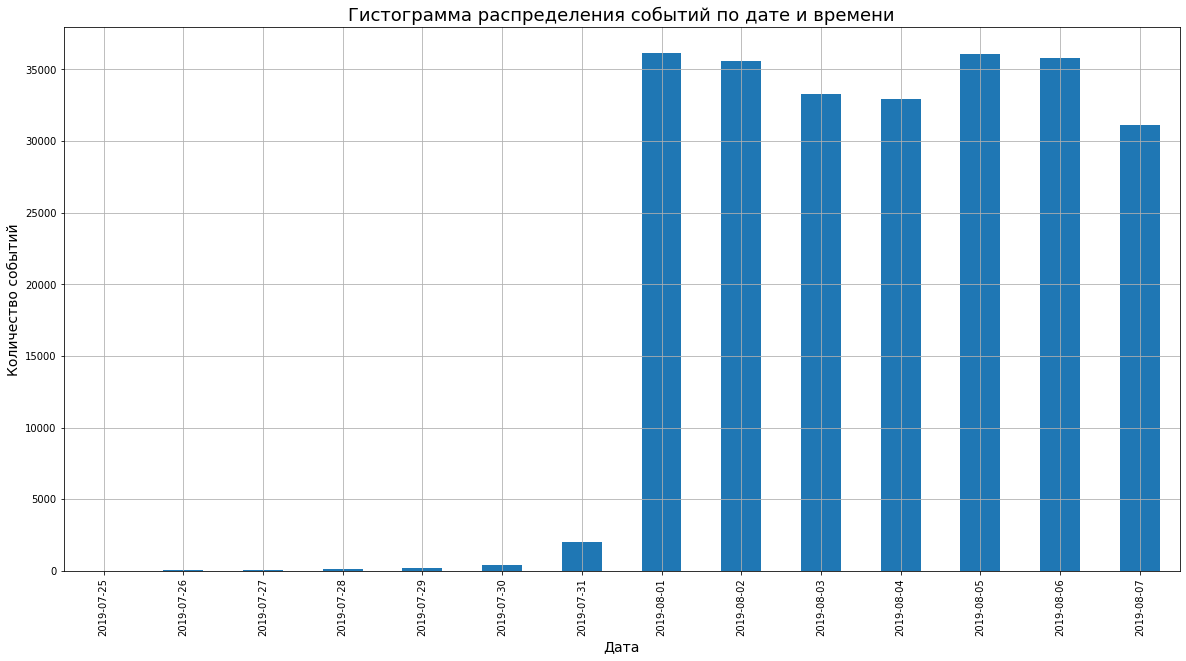

In [10]:
#Группирую данные
event_date = df.groupby('event_dt')['event_dt'].count()
event_date.plot(figsize=(20,10), x='event_dt', y='count', kind='bar', grid=True)
plt.title('Гистограмма распределения событий по дате и времени',fontsize=18)
plt.xlabel('Дата',fontsize=14)
plt.ylabel('Количество событий',fontsize=14)
plt.show()

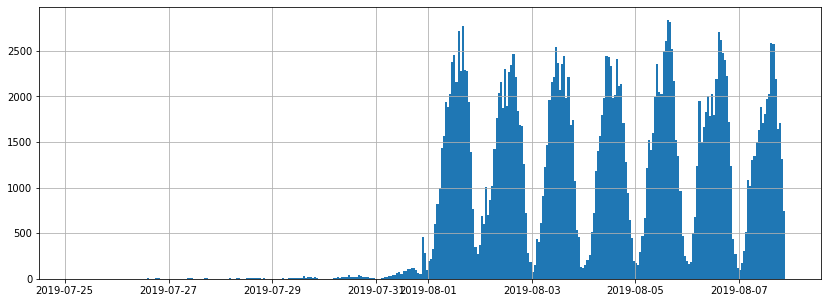

In [11]:
df['event_date_time'].hist(bins=14*24, figsize=(14, 5));

Исходя из данных. представленных на диаграмме видим, что в первые дни проведения теста до 31.07 данные явно не полные, их слишком мало, количество событий в разы меньше, чем в остальные даты. Стабильное количество событий наблюдаем с 01.08 по 07.08. Логично для дальнейшей работы оставить только события за этот период. 

In [12]:
#Создам датафрейм, из которого уберу лишние даты
new_df = df.query("event_date_time  > '2019-08-01 00:00:00'")
print('\n Начальная дата {}, конечная дата {}\n'.format(new_df['event_date_time'].min(), new_df['event_date_time'].max()))


 Начальная дата 2019-08-01 00:07:28, конечная дата 2019-08-07 21:15:17



### Проверка количества событий и пользователей после удаления данных

In [13]:
print('Количество событий в логе:', new_df['event_name'].count())
print('Процент "потерянных" событий:', round(new_df['event_name'].count()/df['event_name'].count()*100 - 100, 2))

Количество событий в логе: 240887
Процент "потерянных" событий: -1.16


In [14]:
print('Количество пользователей в логе:', new_df['device_id_hash'].nunique())
print('Процент "потерянных" пользователей:', round(new_df['device_id_hash'].nunique()/df['device_id_hash'].nunique()*100 - 100, 2))

Количество пользователей в логе: 7534
Процент "потерянных" пользователей: -0.23


Количество событий в логе сократилось менее, чем на 2%, количество уникальных пользователей - менее чем на 1%. Такое сокращение до 5% приемлемо, на результаты исследования не повлияет. 

In [15]:
###Проверю наличие в данных информации о пользователях из всех 3 групп
display(new_df.groupby('exp_id').count())

,event_name,device_id_hash,event_timestamp,event_date_time,event_dt
exp_id,,,,,
246,79302,79302,79302,79302,79302
247,77022,77022,77022,77022,77022
248,84563,84563,84563,84563,84563


Видим, что в данных по-прежнему есть информация о пользователях всех трех групп. Можно продолжать исследование. 

## Изучение воронки событий

### Типы событий в логах, их частота

In [16]:
#Считаю количество событий с группировкой по типу события
display(new_df.groupby('event_name')['event_name'].count().sort_values(ascending = False))

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Ожидаемо, самое частое событие в логах - MainScreenAppear - Просмотр главной страницы. Шаг Tutorial - Руководство - интересует далеко не всех пользователей, возможно, это информация на сайте, которую можно пропустить. 

### Количество пользователей совершавших события

In [17]:
#Считаю, сколько пользователи совершили каждое из событий
display(new_df.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False))

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

Общее количество уникальных пользователей в логе 7534, исходя из этого посчитаем, какая доля пользователей совершила каждое из событий хотя бы раз:

In [18]:
display(round(new_df.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending = False)/new_df['device_id_hash'].nunique()* 100))
pd.options.display.float_format = '{:.1f}%'.format

event_name
MainScreenAppear           98.0
OffersScreenAppear         61.0
CartScreenAppear           50.0
PaymentScreenSuccessful    47.0
Tutorial                   11.0
Name: device_id_hash, dtype: float64

Таким образом: 98% пользователей хотя бы 1 раз просматривали главную страницу, 61% - просматривали страницу с ценами, 50% переходили в корзину, 47% увидели страницу с информацией обуспешной оплате покупки, 11% пользователей просмотрели руководство. 

### Последовательность событий

Предполагаю, что чаще всего первым  событием является MainScreenAppear либо OffersScreenAppear, думаю, что пользователи могут попадать сразу на страницу с ценами, минуя главную (например, если переходят по прямой ссылке или из пуш-сообщения), т.е. эти действия не всегда и не обязательно последовательны. 

Далее пользователь совершает выбор и переходит в корзину - CartScreenAppear, затем производит оплату и видит  PaymentScreenSuccessful. Скорее всего эти два событи - последовательны, в том случае, если на сайте нет, например,кнопки быстрой оплаты минуя корзину.  

Не считаю, что просмотр Tutorial - это последний шаг, вполне возмжны сценарии, когда Руководство смотрят, чтобы лучше ознакомиться с продуктом/сформировать мнение перед покупкой. Может быть это руководство по использованию приложения, тогда многие пользователи могут его пропукать, если интерейс приложения итак достаточно интуитивно-понятнй. 

Т.е. предположительно, последовательность событий такая:

1. MainScreenAppear  
2. OffersScreenAppear
3. CartScreenAppear 
4. PaymentScreenSuccessful 

### Подсчет доли пользователей, которая проходит на следующий шаг воронки событий

In [19]:
#Создам сводную с количеством пользователей на каждое событие, сразу удалю событие Tutorial, т.к. в воронке его учитывать не нужно
events_df = new_df.pivot_table(index='event_name',values='device_id_hash',aggfunc='nunique').sort_values(by = 'device_id_hash', ascending = False)
events_df.drop(['Tutorial'], inplace=True)
display(events_df)

,device_id_hash
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539


In [20]:
#подсчитаю долю пользователей, которые переходят на следующий шаг воронки
events_df['conversion'] = events_df.device_id_hash/events_df.device_id_hash.shift(1)*100
display(events_df)

,device_id_hash,conversion
event_name,,
MainScreenAppear,7419,NaN
OffersScreenAppear,4593,61.9%
CartScreenAppear,3734,81.3%
PaymentScreenSuccessful,3539,94.8%


Видим, что на шаг OffersScreenAppear переходит 61.9% пользователей с шага MainScreenAppear. 
На экран CartScreenAppear переходит 81.3% пользователей с шага OffersScreenAppear и на последний шаг PaymentScreenSuccessful из корзины переходит 94,8% пользователей. 

Больше всего пользователей теряется при переходе на шаг OffersScreenAppear, на этом шаге видим самую низкую конверсию - 61,9%. 

In [21]:
#Посчитаем, какая доля пользователей доходит до последнего шага
print('От первого события до оплаты доходит', round(events_df['device_id_hash'].iloc[3]/events_df['device_id_hash'].iloc[0], 2)*100, '% пользователей')

От первого события до оплаты доходит 48.0 % пользователей


## Анализ результатов эксперимента

In [22]:
#Добавлю названия групп для удобства в дальнейшей работе
def group_name(exp_id):
    '''Возвращает название группы'''
    if exp_id == 246:
        return "A1"
    if exp_id == 247:
        return "A2"
    if exp_id == 248:
        return "B"

new_df['group'] = new_df['exp_id'].apply(group_name)
new_df.head(15)

,event_name,device_id_hash,event_timestamp,exp_id,event_date_time,event_dt,group
2826,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01,A1
2827,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01,A1
2828,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01,A1
2829,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01,A1
2830,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01,A2
2831,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01,A2
2832,OffersScreenAppear,3737462046622621720,1564618226,246,2019-08-01 00:10:26,2019-08-01,A1
2833,MainScreenAppear,3737462046622621720,1564618247,246,2019-08-01 00:10:47,2019-08-01,A1
2834,MainScreenAppear,3737462046622621720,1564618270,246,2019-08-01 00:11:10,2019-08-01,A1
2835,MainScreenAppear,3737462046622621720,1564618280,246,2019-08-01 00:11:20,2019-08-01,A1


In [23]:
#Посчитаю количество уникальных пользователей в каждой группе эксперимента
display(new_df.groupby('group')['device_id_hash'].nunique())

group
A1    2484
A2    2513
B     2537
Name: device_id_hash, dtype: int64

Итак, группа A1 - 2484 пользователя, группа A2 - 2513 пользователей, группа B - 2537 пользователей. 

### Проверка наличия разницы между выборками

In [24]:
#Для дальнейшей работы создам датафрейм с количеством уникальных пользователей по событиям в разрезе контрольгых групп
final_df = new_df.pivot_table(index='event_name',columns='group',values='device_id_hash',aggfunc='nunique').sort_values\
(by = 'A1', ascending=False)
display(final_df)

group,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


In [25]:
final_df.loc['total_amount'] = new_df.groupby('group')['device_id_hash'].nunique()
final_df

group,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279
total_amount,2484,2513,2537


###  А/А-тест, проверяем, есть ли разница между выборками A1 и A2

В дальнейшем гипотезу нужно будет проверить на нескольких группах, поэтому удобнее сразу подготовить функцию для проверки гипотезы о равенстве долей. 

Т.к. будет проводиться множественный тест, нужно снизить вероятность ложнопозитивного результата. Для корректировки уровня значимости буду применять метод Бонферрони. 

Проверять будем 16 гипотез, уровень значимости в функции уменьшим пропорционально количеству проверяемых гипотез.

In [26]:
#Функция для проверки гипотез
def hypothesis_testing (df, column1, column2, alpha):
   
    events = df.index 
    for i in range(1, 5):
        alpha = alpha
        bonferroni = alpha / 16 #Применяю метод Бонферрони
        row1 = np.array([df.loc['total_amount', column1], df.loc['total_amount', column2]])
        row2 = np.array([df.loc[events[i], column1], df.loc[events[i], column2]])
       
        p1 = row2[0] / row1[0]
        p2 = row2[1] / row1[1]
        p_combined = (row2[0] + row2[1]) / (row1[0] + row1[1])
        difference = p1 - p2
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/row1[0] + 1/row1[1]))
        distr = st.norm(0, 1)
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('p-значение: ', p_value)
        if (p_value < bonferroni):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

Сформулируем гипотезы.

Нулевая:  между долями в выборках статистически значимой разницы нет.

Альтернативная: между долями в выборках статистически значимая разница есть.

В качестве уровня значимости alpha беру 0.05 (5%).

In [27]:
AA = hypothesis_testing(final_df, 'A1', 'A2', 0.05)
print(AA)

p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


На основании проверки гипотезы делаем вывод, что между долями в выборках A1 и A2 статистически значимой разницы нет, т.е. трафик, разбиение на группы и инструменты проведения A/A-теста корректны. 

### A/B тест, сравниваем результаты группы B с каждой из контрольных групп и с объединенной группой

In [28]:
final_df['AA'] = final_df['A1'] + final_df['A2']
display(final_df)

group,A1,A2,B,AA
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358
Tutorial,278,283,279,561
total_amount,2484,2513,2537,4997


Гипотезы не меняем:

Нулевая:  между долями в выборках статистически значимой разницы нет.

Альтернативная: между долями в выборках статистически значимая разница есть.

В качестве уровня значимости alpha беру 0.05 (5%).

In [29]:
A1B = hypothesis_testing(final_df, 'A1', 'B', 0.05)
print(A1B)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [30]:
A2B = hypothesis_testing(final_df, 'A2', 'B', 0.05)
print(A2B)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [31]:
AAB = hypothesis_testing(final_df, 'AA', 'B', 0.05)
print(A2B)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


По итогам множественного теста не отвергаем нулевую гипотезу: делаем вывод о том, что разницы между группами нет. Т.е. поведение пользователей в группе B не изменилось, не отличается от поведения пользователей групп A1 и A2, изменение шрифтов на пользовательскую активность не повлияло. 

### Проверка корректности применяемого при проверке гипотез уровня значимости 

При проверке гипотез ранее я брала уровень значимости 0,05. Проверю изменятся ли результаты проверки гипотез, если в качестве уровня значимости буду применять 0,01 (1%), т.е. дополнительно снижаю уровень значимости. 

Гипотезы не меняются:

Нулевая:  между долями в выборках статистически значимой разницы нет.

Альтернативная: между долями в выборках статистически значимая разница есть.

В качестве уровня значимости alpha беру 0.01 (1%).

In [32]:
A1B = hypothesis_testing(final_df, 'A1', 'B', 0.01)
print(A1B)

p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [33]:
A2B = hypothesis_testing(final_df, 'A2', 'B', 0.01)
print(A2B)

p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


In [34]:
AAB = hypothesis_testing(final_df, 'AA', 'B', 0.01)
print(A2B)

p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
None


В итоге изменение, а именно - уменьшение уровня статистической значимости alpha, не изменило результаты проверки гипотез. Оснований считать доли групп разными по всем действиям во всех группах по-прежнему нет, т.е. изменение шрифта все-таки не повлияло на пользовательскую активность. 

## Общие выводы

Целью исследования было выяснить, как влияет изменение шрифта в приложении на пользовательскую активность. 

Анализ был проведен на основе данных из файла logs_exp.csv. Мы располагали данными по пользовательской активности в трёх группах: 2 контрольные со старыми шрифтами и 1 экспериментальная — с новыми.

Перед проведением анализа и проверки гипотез данные были предобработаны: проверены на пропуски, приведены к нужным типам, проверены на дубликаты и очищены от них. Для удобства работы были отредактированы названия столбцов, также в процессе работы добавлялись с толбцы с новымми данными/необходимыми высилениями.  

На первом этапе был проведен анализ воронки событий. 

Сама воронка предположительно следующая:

1. MainScreenAppear  
2. OffersScreenAppear
3. CartScreenAppear 
4. PaymentScreenSuccessful 

По итогам анализа получили следующие данные:

На шаг OffersScreenAppear переходит 61.9% пользователей с шага MainScreenAppear. 

На экран CartScreenAppear переходит 81.3% пользователей с шага OffersScreenAppear.

И на последний шаг PaymentScreenSuccessful из корзины переходит 94,8% пользователей. 

Больше всего пользователей теряется при переходе на шаг OffersScreenAppear, на этом шаге видим самую низкую конверсию - 61,9%. 

Таким образом:

+ Больше всего пользователей "теряем" на этапе перехода с главной страницы на страницу с ценами OffersScreenAppear - 38%;

+ 19% пользователей завершают использование приложения без заказа, не переходя в корзину. 

+ 48% пользователей приложения доходят до оплаты покупки. 

Далее были проанализированы данные по результатам эксперимента, для этого проводилась проверка гипотез о равенстве долей. Т.к. гипотеза проверялось большое количество раз, чтобы снизить групповую вероятность ошибки первого рода и скорректировать требуемые уровни значимости дополнительно применялся метод Бонферрони. 

Гипотезы были сформулированы такии образом:

Нулевая:  между долями в выборках статистически значимой разницы нет.

Альтернативная: между долями в выборках статистически значимая разница есть.

В качестве уровня статистической значимости alpha на первом этапе брала 0,05 (5%), далее для проверки корректности результатов заменила его на 0,01(1%). 

По итогам анализа A/A/B-теста, можно сделать следующий вывод:

+ Статистически значимой разницы между долями в группах A1, A2, B и AA нет. 

Т.е. поведение пользователей после изменения шрифтов в приложении - не изменилось. Доли пользователей, переходящих с одного этапа воронки на другой не именились ни в большу, ни в меньшую стороны. 

Таким образом, проведенное тестирование можно считать успешным, изменение шрифтов в приложении "не отпугнуло" клиентов, не повлияло на показатели продажи, т.е. можно смело принимать решение об изменении шрифтов во всем приложении дл всех пользователей. 